# Information management
## word2vec을 이용한 기억속 영화 찾기(doc2vec)
## 1. Read Data

In [1]:
import numpy as np
import pandas as pd
import os, re
from konlpy.tag import Twitter
from gensim.models.doc2vec import LabeledSentence, Doc2Vec
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#from konlpy.utils import pprint
#from gensim.models import Word2Vec
#from sklearn.feature_extraction.text import TfidfVectorizer

d:\anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# change directory
os.chdir('D:/UNIST/17-2학기 자료/IM')
# read data
df=pd.read_csv('formodeling.csv',encoding='cp949')
del df['Unnamed: 0.1']
del df['Unnamed: 0']
df.shape

(38614, 9)

## 1-1. Train & Test Set split

In [3]:
# split train test data (영화별 비율 유지)
train,test = train_test_split(df, random_state=42, train_size=0.8, test_size=0.2, stratify=df.answer)

print(len(train.answer.value_counts().index))
print(len(test.answer.value_counts().index))
print(train.shape)
print(test.shape)

3788
2720
(30891, 9)
(7723, 9)


In [16]:
train.head()

,answer,q_gen,question,synopsis,time,len_question,len_answer,count,new_index
18817,여자의 이별,없음,내공 50드립니다.\r\r\r\n\r\r\r\n옛날 영화이며(아마 1980년대 90...,셜리 발렌타인(Shirley Valentine-Bradshaw: 폴린 콜린스 분)의...,2015.06.09. 21:16,458,6,2,1344
34093,미래를 걷는 소녀,"로맨스, 멜로 영화",일본영화인데 여주?가 어떤건물계단에서 핸드폰을 실수로 떨어트렸는데 그게 옛날?로 가...,"SF작가를 꿈꾸는 평범한 여고생 미호는 어느날 빌딩 계단을 내려가던 중, 지진이 일...",2016.04.03. 16:21,144,9,75,501
34292,체인드,없음,줄거리는 연쇄살인마가 그 엄마는 죽이고 아이를 데려다가 키우며 자신의 살인을 돕게한...,9살의 어린 소년 팀은 우연히 엄마와 탄 택시에서 끔찍한 변을 당하고 만다. 외딴 ...,2016.02.16. 15:37,86,3,16,1077
30632,플라이트플랜,없음,일단 외국영화였고..\r\r\r\n\r\r\r\n엄마와 딸이 비행기타는데\r\r\r...,"37,000피트 상공의 비행기를 배경으로 펼쳐지는 스릴러 영화로 조디 포스터가 맡은...",2016.03.20. 13:09,100,6,18,943
26035,디스 민즈 워,"액션, 무협 영화",영화 제목이 생각안나서 그러는데요.\r\r\r\n뭐라해야되지 특수요원 남자 2명이서...,세계 최고의 실력을 가진 CIA 특수요원 터크(톰 하디)와 프랭클린(크리스 파인)....,2014.05.04. 22:41,139,7,56,2281


## 2. Pos tagging with Twitter - 명사, 형용사, 동사

In [4]:
# unique 한 영화만 들어있는 새로운 dataframe 만들기
dff=df.drop_duplicates(subset='new_index')
dff.shape

(3788, 9)

In [5]:
stop_words=['영화','설명','외국영화','죄송합니다','제목','페북','내용','배우','기억','영화관','어릴때','알려','답변','내공','혹시',
            '주인공','일본','장르','장면','년도','년전','꼭좀','찾다','예전','티비','프로그램','질문','외국','유명하다']

In [6]:
import time
start = time.time();

# 특정 태그만 남기기 Twitter version synopsis
tw=Twitter()
synop_list=[]
for synop in dff.synopsis:
    synop=tw.pos(synop,norm=True,stem=True)
    word_list=[]
    for word, tag in synop:
        if tag in ['Noun','Adjective','Verb']:
            if len(word)>1:
                word_list.append(word)
    synop_list.append(word_list)
    
end = time.time();
print(end-start)

32.245187520980835


In [7]:
# 특정 태그만 남기기 Twitter version train_question
start = time.time();
question_list=[]
for q in train.question:
    q=tw.pos(q,norm=True,stem=True)
    word_list=[]
    for word, tag in q:
        if tag in ['Noun','Adjective','Verb']:
            if len(word)>1:
                if word not in stop_words:
                    word_list.append(word)
    question_list.append(word_list)
    
end = time.time();
print(end-start)

151.50730276107788


# 3. Doc2vec modeling

### 1) Labeled sentence 생성 for modeling

In [8]:
# labeled sentence 생성
from gensim.models.doc2vec import LabeledSentence, Doc2Vec, TaggedDocument

doc_list=[]
dff_index=list(dff.answer)
train_index=list(train.answer)

# synopsis만 추가
for i in range(len(dff)):
    doc=TaggedDocument(synop_list[i], [dff_index[i]])
    doc_list.append(doc)

# train question 추가
for i in range(len(train)):
    doc=TaggedDocument(question_list[i], [train_index[i]])
    doc_list.append(doc)    

### 2) Query setting for outout

In [10]:
# Queary setting 
start = time.time();

query_list=[]
for q in test.question:
    q=tw.pos(q,norm=True,stem=True)
    word_list=[]
    for word, tag in q:
        if tag in ['Noun','Adjective','Verb']:
            if len(word)>1:
                if word not in stop_words:
                    word_list.append(word)
    query_list.append(word_list)
    
end = time.time();
print(end-start)

36.13236689567566


### 3) making accuracy estimate function

In [11]:
# return accuracy function
def get_model_accuracy(model,t):
    # query input
    acc_list=[]
    test_answer_list=list(test.answer)

    i=0
    for query in query_list:
        new_vector = model.infer_vector(query,alpha=0.001)
        sims = model.docvecs.most_similar([new_vector],topn=t)

        # 정확도 구하기
        accuracy=[]
        output_list=[]
    
        for title, similarity in sims:
            output_list.append(title)
       
        if test_answer_list[i] in output_list:
            accuracy.append(1)
        else:
            accuracy.append(0)
    
        i=i+1

        acc_list.append(sum(accuracy))

    results=(sum(acc_list)/len(acc_list))
    
    return results

In [30]:
test.head()

,answer,q_gen,question,synopsis,time,len_question,len_answer,count,new_index
34706,더 캣,코미디영화,지금 중3이고 유치원생떄 본기억이 나는데 남매가 살고 있었는데 이상한 광대같이 생긴...,모든 스케줄을 PDA로 관리하는 새침한 ‘샐리’와 인생자체가 불만이며 산만하기 그지...,2015.08.06. 13:29,154,3,71,3741
24065,스카이라인,"SF, 판타지 영화",제가 진짜 기억하려해도안나는영화가있는데여..\r\r\r\n외계인이나오는 영화인데 내...,제로드(에릭 벌포)와 일레인(스코티 톰슨) 커플은 친구 ‘테리’의 생일파티에 초대받...,2014.08.01. 23:21,198,5,92,2833
12900,마이너리티 리포트,"SF, 판타지 영화",생각이안나서 질문드려요\r\r\r\r\n영화내용중 한장면만 생각나서ㅠㅠ\r\r\r\...,"2054년 워싱턴, 범죄가 일어나기 전 범죄를 예측해 범죄자를 단죄하는 최첨단 치안...",2014.06.21. 20:30,121,9,43,103
19204,콜로니:지구 최후의 날,"공포, 스릴러 영화",영화 내용이 잘 기억이 안나는데\r\r\r\n지구가 멸망했나 아무튼 추위에 지하에서...,"2144년, 갑작스러운 지구 온난화 이후 빙하기가 찾아왔다. 가까스로 살아남은 생존...",2015.05.11. 19:52,150,12,36,971
5646,코만도,"공포, 스릴러 영화",그 딸이 납치돼서 아빠가 찾으로다니는데 찾다가어떤여자랑 눈맞아서 마지막에결혼하고 아...,세계 각처의 분쟁 해결을 위해 싸우던 특수부대 코만도의 매트릭스(Matrix: 아놀...,2015.03.14. 12:51,132,3,3,3380


In [40]:
ss = model.docvecs.most_similar([model.infer_vector(query_list[3])])
ss

[('콜로니:지구 최후의 날', 0.40398263931274414),
 ('원헌드레드', 0.2937268316745758),
 ('써티 데이즈 오브 나이트', 0.29140979051589966),
 ('최후의 용사', 0.28481325507164),
 ('혹성탈출', 0.28459781408309937),
 ('스타쉽 트루퍼스 2', 0.27995389699935913),
 ('GP506 (GP506, 2007)', 0.2747943103313446),
 ('파이어폭스', 0.2723645865917206),
 ('루인스', 0.27033764123916626),
 ('임팩트', 0.25911882519721985)]

In [12]:
# return correct index list
def get_correct_movie_info(model):
    # query input
    correct_list_index=[]
    wrong_list_index=[]
    
    test_answer_list=list(test.answer)

    i=0
    for query in query_list:
        new_vector = model.infer_vector(query,alpha=0.001)
        sims = model.docvecs.most_similar([new_vector])

        # 맞춘 영화 정보 구하기
        output_list=[]

        for title, similarity in sims:
            output_list.append(title)
        
        if test_answer_list[i] in output_list:
            correct_list_index.append(i)
        else:
            wrong_list_index.append(i)
            
        i=i+1
    
    return correct_list_index

### 4) parameter tuning for best parameter setting

#### prameter tuning
hs = if 1, hierarchical softmax will be used for model training. If set to 0 (default), and negative is non-zero, negative sampling will be used.

negative = if > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). Default is 5. If set to 0, no negative samping is used.

alpha is the initial learning rate (will linearly drop to min_alpha as training progresses).

In [13]:
# modeling
start = time.time();
model = Doc2Vec(doc_list, alpha=0.1, size= 300, window = 6, min_count = 1, workers=1, seed = 42, iter=5, hs=1,negative=3)
end = time.time();
print(end-start)

39.741217851638794


In [14]:
# get accuracy
print(get_model_accuracy(model,10))

0.737407743105011


### 5) Results analysis

In [64]:
# get correct data frame
c=get_correct_movie_info(model)
correct_df=test.iloc[c,:]

In [146]:
# make accuracy list
acc=[]
for i in range(1,11):
    acc.append(get_model_accuracy(model,i))

print(acc)

[0.5764599248996504, 0.6305839699598602, 0.6601061763563382, 0.6791402304803833, 0.6882040657775476, 0.7036125857827269, 0.7131943545254434, 0.7212223229315033, 0.7276964910009064, 0.7357244594069662]


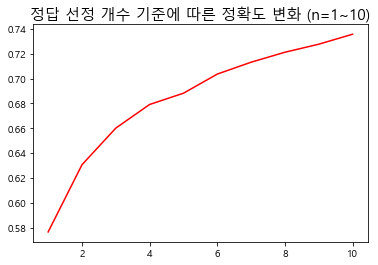

In [147]:
# 정답 선정 개수 기준에 따른 정확도 변화 plot

#matplotlib 한글 깨짐 방지 코드
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name) 

# plot
plt.plot(range(1,11), acc, color='red')
plt.title("정답 선정 개수 기준에 따른 정확도 변화 (n=1~10)",fontsize=15)
plt.show()

In [102]:
# 
min_c=min(correct_df['count'])
max_c=max(correct_df['count'])
correct_count_list=[]

min_t=min(test['count'])
max_t=max(test['count'])
all_count_list=[]

for i in range(min_c,max_c):
    correct_count_list.append(sum(correct_df['count']==i))
    
for i in range(min_t,max_t):
    all_count_list.append(sum(test['count']==i))

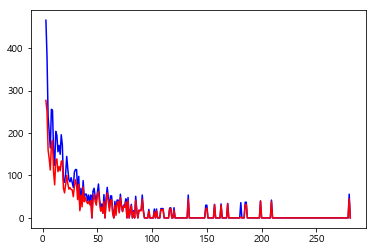

In [113]:
# 영화당 질문별 
plt.plot(range(min_t,max_t), all_count_list, color='blue')
plt.plot(range(min_c,max_c), correct_count_list, color='red')
plt.title("",fontsize=15)
plt.show()

In [ ]:
# plot
plt.plot(range(1,21), acc, color='red')

plt.title("정답 선정 개수 기준에 따른 정확도 변화 (n=1~20)",fontsize=15)
plt.show()

### 6) Results (Accuracy)

#### score board topn=20
model = Doc2Vec(doc_list, alpha=0.1, size= 300, window = 6, min_count = 1, workers=1, seed = 42, iter=5, hs=1,negative=3) --> 77.5

#### score board topn=10
model = Doc2Vec(doc_list, size= 300, window = 6, min_count = 1, workers=1, seed = 42, iter=5, hs=1) --> 52.8  
model = Doc2Vec(doc_list, alpha=0.1, size= 300, window = 6, min_count = 1, workers=1, seed = 42, iter=5, hs=1,negative=3) --> 73.5

#### score board topn=5
model = Doc2Vec(doc_list, alpha=0.1, size= 300, window = 6, min_count = 1, workers=1, seed = 42, iter=5, hs=1,negative=3) --> 69


#### score board topn=1
model = Doc2Vec(doc_list, alpha=0.1, size= 300, window = 6, min_count = 1, workers=1, seed = 42, iter=5, hs=1,negative=3) --> 57.3


## 7) save model

In [ ]:
# store the model to mmap-able files
model.save('my_model.doc2vec')
#load the model back
#model_loaded = Doc2Vec.load('my_model.doc2vec')

In [133]:
test.question[34706]

'지금 중3이고 유치원생떄 본기억이 나는데 남매가 살고 있었는데 이상한 광대같이 생긴 사람이 들어와서 같이 놀면서 집안을 쑥대밭으로 만든 장면도 기억나고 홈쇼핑 찍는것도 기억나고 집안에 보라색 물들이 가득차서 할머니는 둥둥떠다는거 까지 기억나는데 무슨 영화였는지 정말 궁금해요ㅜ'

In [143]:
# query input
new_vector = model.infer_vector(query_list[10],alpha=0.001)
sims = model.docvecs.most_similar([new_vector])
sims

[('스파이더위크가의 비밀', 0.2941552400588989),
 ('네트 2.0', 0.2685217261314392),
 ('솔로몬 케인', 0.24590462446212769),
 ('워하우스', 0.2277802675962448),
 ('타임크라임', 0.2127988636493683),
 ('윈드토커', 0.20705699920654297),
 ('c', 0.20396682620048523),
 ('잠베지아: 신비한 나무섬의 비밀', 0.1999140977859497),
 ('홀즈', 0.1982620656490326),
 ('이미테이션 게임', 0.19305674731731415)]

In [ ]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(test_corpus))
inferred_vector = model.infer_vector(test_corpus[doc_id])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

# Compare and print the most/median/least similar documents from the train corpus
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(test_corpus[doc_id])))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

# 아래는 참고 코드

### 3) TF-IDF Synopsis

In [223]:
# TF-IDF 만들기 (synopsis)
corpus=[]
for doc in synop_list:
    corpus.append(' '.join(doc))

In [148]:
# TF-IDF modeling
#idf_maker=TfidfVectorizer(min_df=3)
#tf_idf=idf_maker.fit_transform(corpus).toarray()

In [ ]:
idf_maker = TfidfVectorizer(min_df=2)
tf_idf = idf_maker.fit_transform(word_list).toarray()
tf_idf_dtm = pd.DataFrame(tf_idf, columns= idf_maker.get_feature_names(), 
                      index= ['taxi', 'gunhamdo', 'young_police', 'war_of_species', 'nomuhyun', 'summer_500', 'dung','sunshine',
                              'annabel', 'spiderman'])
tf_idf_dtm

In [ ]:
# 중복제거
def remove_duplicates(li):
    my_set=set()
    res=[]
    for e in li:
        if e not in my_set:
            res. append(e)
            my_set.add(e)
    return res

# Babel practice code

- 대학생 커뮤니티에서 수집한 174만개의 문장을 Step2에서의 방법으로 형태소 분석하고, 단어의 리스트 포맷으로 만듦.  
- 포맷 : [ ["word1/pos1", "word2/pos2", "word3/pos3", ... ], ["word4/pos4", "word5/pos5", ... ], ... ] 
- __사정상 데이터는 공개 불가 ㅜ__

- 앞서 만든 word2vec 모델은 기존 1-hot 벡터표현법에 비해 차원(dimension)이 상당히 줄어들었지만, 그래도 300차원..
- 이를 평면상에 시각화해보기 위해서는 t-SNE를 이용하여 차원을 2차원으로 축소해야함.
- t-SNE는 scikit-learn에서 제공.

In [259]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [260]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000) 
# 여기서 중요한 것은 n_components만큼 차원을 축소함. Cartarian 좌표계로 시각화하기 위해 2차원으로 축소.

In [261]:
# numpy객체 출력시 소숫점 출력안함
np.set_printoptions(suppress=True)

In [264]:
vectors = model_w2v.syn0
labels = model_w2v.index2word

AttributeError: 'Word2Vec' object has no attribute 'syn0'

In [ ]:
# 이것도 오오오오오오래걸림...
import time
start = time.time();
vectors_simple = tsne.fit_transform(vectors)
end = time.time();
print end -start

In [ ]:
# 차원축소된 벡터 저장.
#with open('vectors_simple.txt', 'w') as f:
#    pickle.dump(vectors_simple, f)

In [ ]:
# 저장된 벡터 불러오기.
#with open('vectors_simple.txt', 'rb') as f:   
#    vectors_simple = pickle.load(f)

In [ ]:
from bokeh.plotting import figure, show, output_notebook, output_file

In [ ]:
#output_file("word2vec_tsne.html") # 시각화 결과물을 "word2vec_tsne.html" 이름으로 export
output_notebook() # 시각화 결과물을 jupyter 노트북에 보여줌.

In [ ]:
from bokeh.models import HoverTool, ColumnDataSource

source = ColumnDataSource(
        data=dict(
            x=vectors_simple.T[0],
            y=vectors_simple.T[1],
            word=labels,
        )
    )


hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("word", "@word"),
        ]
    )
TOOLS = "pan,wheel_zoom,box_zoom,reset,resize"

In [ ]:
p = figure(plot_width=700, plot_height=700, tools=[TOOLS,hover], title="Words of Univ Students")
p.circle('x', 'y', size=7, source=source, alpha=0.4, fill_color="red", line_color="#ff9900")

show(p)

In [ ]:
# 강의 코드 
lines=text.split('\r\n')
result=[]
for line in lines:
    r=[]
    malist=twitter.pos(line, norm=True, stem=True)
    for (word, pumsa) in malist:
        if not mumsa in ['josa']:
            r.append(word)
    result.append((" ".join(r)).strip())
    
output=(" ".join(results)).strip()

with open('aa.txt','w', encoding='utf-8') as fp:
    fp.write(output)

data=word2vec.Linesentenc('adf.wakati')
model=word2vec.Word2Vec(data, size=200, window=10, hs=1, min_count=2, sq=1)
model.save("")


noun_adv_verb_only_list = [word, part for word, part in test_docs1[10][0] if part == "Verb" or part == "Adjective" or part == "Noun"]

# unload useless memory
model.init_sims(replace=True)

# 강의 코드 
lines=text.split('\r\n')
result=[]
for line in lines:
    r=[]
    malist=twitter.pos(line, norm=True, stem=True)
    for (word, pumsa) in malist:
        if not mumsa in ['josa']:
            r.append(word)
    result.append((" ".join(r)).strip())
    
output=(" ".join(results)).strip()
